<a href="https://colab.research.google.com/github/SharmilNK/XAI/blob/main/assignments/Mechanistic_Interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mechanistic Interpretability Assignment

Sharmil N

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SharmilNK/XAI/blob/main/assignments/Mechanistic_Interp.ipynb)


A tiny CNN was trained to classify images of circles, triangles, squares, and rectangles. Analysis of filters and activations showed that specific neurons specialize in detecting distinct geometric features—like edges, corners, and curves—that the model relies on for accurate shape recognition.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from tqdm import tqdm
import os

Generate synthetic pictures of shapes (square, rectangle, triangle, circle).
Each image is 64×64 pixels, black background with a white shape.

Input:
Just the shape name (e.g., "square", "triangle").
Output:
A grayscale image (like a black-and-white picture).


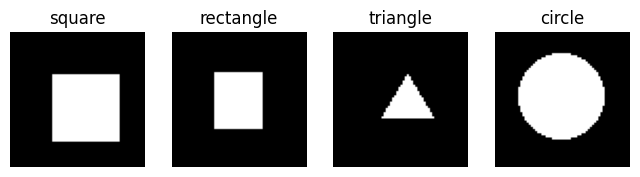

In [ ]:
IMG_SIZE = 64  # 64x64 images

def draw_shape(shape, img_size=IMG_SIZE, jitter=True):
    # returns a grayscale PIL Image with a single centered shape
    # shape in ['square','rectangle','triangle','circle']
    img = Image.new('L', (img_size, img_size), color=0)  # black background
    draw = ImageDraw.Draw(img)
    pad = 8
    # define bounding box with some random jitter
    if shape == 'square':
        side = random.randint(img_size//3, img_size//2)
        x0 = (img_size - side)//2 + (random.randint(-4,4) if jitter else 0)
        y0 = x0
        bbox = [x0, y0, x0+side, y0+side]
        draw.rectangle(bbox, fill=255)
    elif shape == 'rectangle':
        w = random.randint(img_size//3, img_size//2)
        h = random.randint(img_size//4, img_size//2)
        x0 = (img_size - w)//2 + (random.randint(-6,6) if jitter else 0)
        y0 = (img_size - h)//2 + (random.randint(-4,4) if jitter else 0)
        bbox = [x0, y0, x0+w, y0+h]
        draw.rectangle(bbox, fill=255)
    elif shape == 'circle':
        r = random.randint(img_size//4, img_size//3)
        cx = img_size//2 + (random.randint(-6,6) if jitter else 0)
        cy = img_size//2 + (random.randint(-6,6) if jitter else 0)
        bbox = [cx-r, cy-r, cx+r, cy+r]
        draw.ellipse(bbox, fill=255)
    elif shape == 'triangle':
        # upright isosceles triangle roughly centered
        base = random.randint(img_size//3, img_size//2)
        height = int(base * 0.8)
        cx = img_size//2 + (random.randint(-6,6) if jitter else 0)
        cy = img_size//2 + (random.randint(-6,6) if jitter else 0)
        p1 = (cx, cy - height//2)
        p2 = (cx - base//2, cy + height//2)
        p3 = (cx + base//2, cy + height//2)
        draw.polygon([p1, p2, p3], fill=255)
    else:
        raise ValueError("Unknown shape")
    return img

# display images generated
plt.figure(figsize=(8,2))
shapes = ['square','rectangle','triangle','circle']
for i,s in enumerate(shapes):
    plt.subplot(1,4,i+1)
    plt.imshow(draw_shape(s), cmap='gray')
    plt.title(s)
    plt.axis('off')
plt.show()


Wraps all these shape images into a PyTorch “Dataset” object, so they can be fed into the neural network easily.

Input:The number of samples you want (2,000 images).
Image size (64×64).

Output: Splits into Training set (80%)
Validation set (20%)

In [ ]:
class ShapeDataset(Dataset):
    def __init__(self, n_samples=2000, img_size=IMG_SIZE, transform=None):
        self.labels = ['square','rectangle','triangle','circle']
        self.n = n_samples
        self.img_size = img_size
        self.transform = transform
        self.data = []
        self.targets = []
        for _ in range(n_samples):
            lab = random.choice(self.labels)
            img = draw_shape(lab, img_size=img_size, jitter=True)
            self.data.append(img)
            self.targets.append(self.labels.index(lab))
    def __len__(self): return self.n
    def __getitem__(self, idx):
        img = self.data[idx]
        if self.transform:
            img = self.transform(img)
        else:
            img = T.ToTensor()(img)  # 1 x H x W, values 0..1
        return img, self.targets[idx]

# transforms and dataset split
transform = T.Compose([T.ToTensor()])
dataset = ShapeDataset(n_samples=3000, img_size=IMG_SIZE, transform=transform)
train_len = int(0.8 * len(dataset))
val_len = len(dataset) - train_len
train_ds, val_ds = random_split(dataset, [train_len, val_len])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)

print(f"Dataset sizes: train={len(train_ds)}, val={len(val_ds)}")


Dataset sizes: train=2400, val=600


Build a Convolutional Neural Network (CNN).

Input: An image (1 channel = grayscale).

Output:Four indicators to see how strongly the model believes the image is a: Square, Rectangle, Triangle, Circle.


CNNs are really good at recognizing shapes because their first layers learn edges and corners, and later layers learn whole patterns.


In [ ]:
class TinyCNN(nn.Module):
    def __init__(self, n_classes=4):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, padding=2)   # 8 filters
        self.conv2 = nn.Conv2d(8, 12, kernel_size=3, padding=1)  # 12 filters
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear((IMG_SIZE//2)*(IMG_SIZE//2)*12, 32)
        self.fc2 = nn.Linear(32, n_classes)
    def forward(self, x, return_acts=False):
        a1 = F.relu(self.conv1(x))    # B x 8 x H x W
        p1 = self.pool(a1)            # B x 8 x H/2 x W/2
        a2 = F.relu(self.conv2(p1))   # B x 12 x H/2 x W/2
        p2 = a2                       # we keep conv2 activations for interpretability
        flat = p2.flatten(start_dim=1)
        h = F.relu(self.fc1(flat))    # B x 32
        out = self.fc2(h)
        if return_acts:
            return out, {'conv1': a1.detach(), 'conv2': a2.detach(), 'fc1': h.detach()}
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TinyCNN(n_classes=4).to(device)
print(model)


TinyCNN(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=4, bias=True)
)


Train the model

The model learns based on the Train set.
After each batch, it adjusts itself a little (this is backpropagation).
After each epoch, it checks accuracy on the validation set.

Input: Training images and their correct labels.

Output:
A trained model that can now classify shapes.

Training loss (how wrong the model was)

Validation accuracy (how many it got right)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def evaluate(loader):
    model.eval()
    total = 0; correct = 0; loss_sum = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss_sum += float(loss) * xb.size(0)
            preds = logits.argmax(dim=1)
            total += xb.size(0)
            correct += (preds == yb).sum().item()
    return loss_sum/total, correct/total

# train for modest epochs until good perf
n_epochs = 12
for ep in range(n_epochs):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {ep+1}/{n_epochs}")
    for xb, yb in pbar:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'loss': f"{loss.item():.3f}"})
    val_loss, val_acc = evaluate(val_loader)
    print(f" -> Val loss: {val_loss:.3f}, Val acc: {val_acc:.3f}")


Epoch 1/12: 100%|██████████| 38/38 [00:03<00:00, 12.03it/s, loss=0.387]


 -> Val loss: 0.370, Val acc: 0.848


Epoch 2/12: 100%|██████████| 38/38 [00:02<00:00, 14.45it/s, loss=0.242]


 -> Val loss: 0.225, Val acc: 0.913


Epoch 3/12: 100%|██████████| 38/38 [00:02<00:00, 14.62it/s, loss=0.167]


 -> Val loss: 0.191, Val acc: 0.922


Epoch 4/12: 100%|██████████| 38/38 [00:03<00:00, 10.85it/s, loss=0.203]


 -> Val loss: 0.145, Val acc: 0.950


Epoch 5/12: 100%|██████████| 38/38 [00:02<00:00, 14.80it/s, loss=0.163]


 -> Val loss: 0.137, Val acc: 0.945


Epoch 6/12: 100%|██████████| 38/38 [00:02<00:00, 14.72it/s, loss=0.147]


 -> Val loss: 0.128, Val acc: 0.953


Epoch 7/12: 100%|██████████| 38/38 [00:02<00:00, 14.51it/s, loss=0.157]


 -> Val loss: 0.107, Val acc: 0.958


Epoch 8/12: 100%|██████████| 38/38 [00:03<00:00, 10.92it/s, loss=0.137]


 -> Val loss: 0.104, Val acc: 0.962


Epoch 9/12: 100%|██████████| 38/38 [00:02<00:00, 14.63it/s, loss=0.069]


 -> Val loss: 0.172, Val acc: 0.943


Epoch 10/12: 100%|██████████| 38/38 [00:02<00:00, 14.49it/s, loss=0.008]


 -> Val loss: 0.173, Val acc: 0.945


Epoch 11/12: 100%|██████████| 38/38 [00:02<00:00, 14.48it/s, loss=0.151]


 -> Val loss: 0.093, Val acc: 0.968


Epoch 12/12: 100%|██████████| 38/38 [00:03<00:00, 10.96it/s, loss=0.069]


 -> Val loss: 0.078, Val acc: 0.978


Test on Validation set

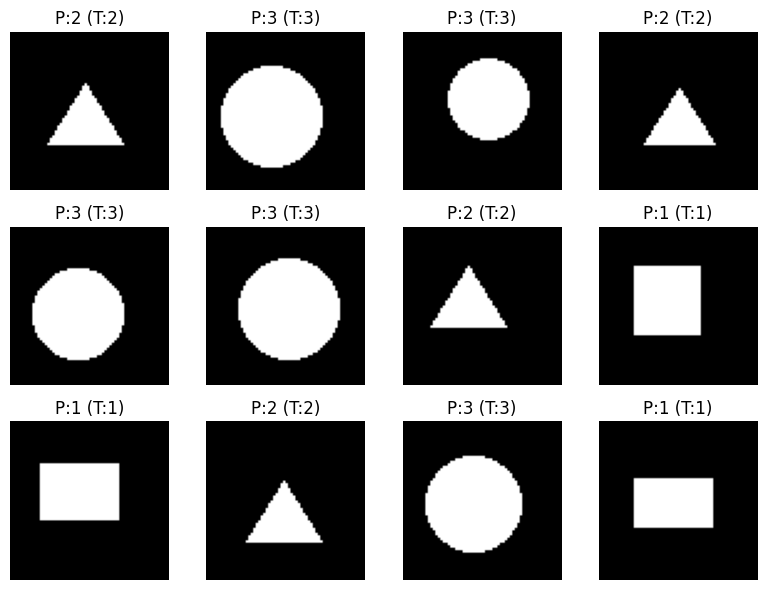

In [ ]:

model.eval()
batch = next(iter(val_loader))
imgs, labels = batch
with torch.no_grad():
    imgs_dev = imgs.to(device)
    logits, acts = model(imgs_dev, return_acts=True)
    preds = logits.argmax(dim=1).cpu().numpy()

# visualize grid of a few images with predicted/true labels
plt.figure(figsize=(8,6))
for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(imgs[i].squeeze().numpy(), cmap='gray')
    plt.title(f"P:{preds[i]} (T:{labels[i].item()})")
    plt.axis('off')
plt.tight_layout()
plt.show()


Visualize learned conv2 filters (weights)

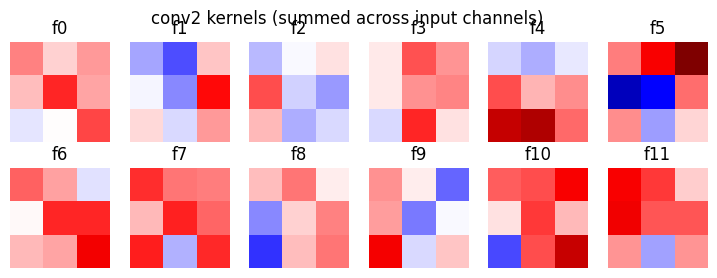

In [ ]:

# conv2 has shape (out_channels, in_channels, k, k)
w = model.conv2.weight.detach().cpu().numpy()  # 12 x 8 x 3 x 3
# we'll visualize each out filter by summing over its input channels
kernels = w.sum(axis=1)  # 12 x 3 x 3
plt.figure(figsize=(9,3))
for i in range(kernels.shape[0]):
    plt.subplot(2,6,i+1)
    plt.imshow(kernels[i], cmap='seismic', vmin=-np.max(np.abs(kernels)), vmax=np.max(np.abs(kernels)))
    plt.title(f"f{i}")
    plt.axis('off')
plt.suptitle("conv2 kernels (summed across input channels)")
plt.show()


Interpretation:

The conv2 kernel visualizations show that different filters have distinct color patterns, indicating sensitivity to various edge directions and textures. Red and blue regions represent positive and negative weights, suggesting that some filters detect vertical or diagonal edges, while others emphasize corners or intensity contrasts in the shapes.




Activation maps for a single example (conv2)

Shows which filters light up (activate) for a given image (triangle).

Input:One image from the validation set.

Output:Heatmaps, each showing where a filter paid attention.


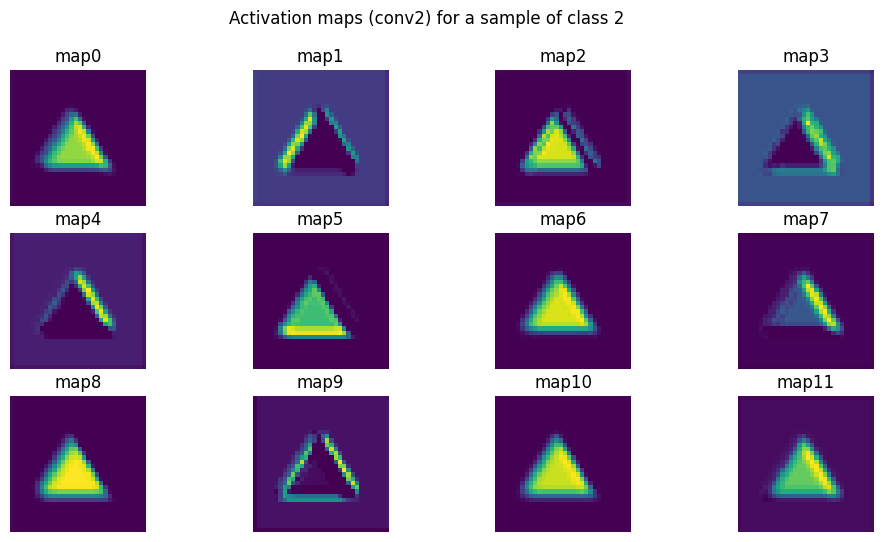

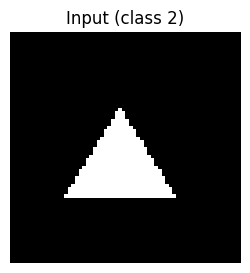

In [ ]:

# pick an example from val set that model predicted correctly
model.eval()
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device); yb = yb.to(device)
        logits, acts = model(xb, return_acts=True)
        preds = logits.argmax(dim=1)
        for idx in range(xb.size(0)):
            if preds[idx].item() == yb[idx].item():
                ex_img = xb[idx:idx+1]
                ex_label = yb[idx].item()
                break
        else:
            continue
        break

conv2_maps = acts['conv2'][0].cpu().numpy()  # (12, H/2, W/2)
n_maps = conv2_maps.shape[0]
plt.figure(figsize=(12,6))
for i in range(n_maps):
    plt.subplot(3,4,i+1)
    plt.imshow(conv2_maps[i], cmap='viridis')
    plt.title(f"map{i}")
    plt.axis('off')
plt.suptitle(f"Activation maps (conv2) for a sample of class {ex_label}")
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(ex_img.cpu().squeeze().numpy(), cmap='gray')
plt.title(f"Input (class {ex_label})")
plt.axis('off')
plt.show()


Interpretation: This tells us which parts of the image matter most to each filter.
The activation maps show that multiple filters in the second convolution layer respond strongly along the edges and corners of the triangle. Bright areas highlight that the model focuses mainly on the triangle’s boundaries, confirming that these filters detect angular shapes and edge patterns essential for identifying triangles.

Top-activating images per filter

Finds which images make each filter the most excited.

Input: validation images and their activations.
Output: For each filter, the top 5 images that activated it most.


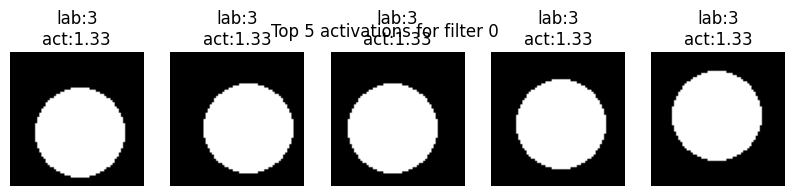

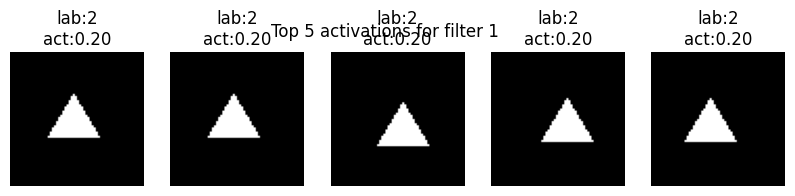

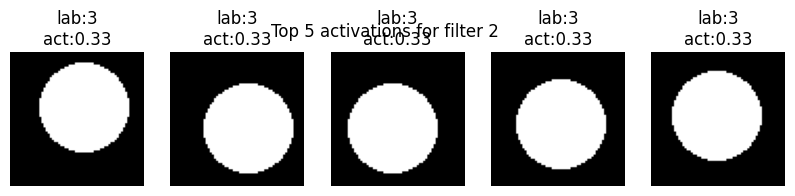

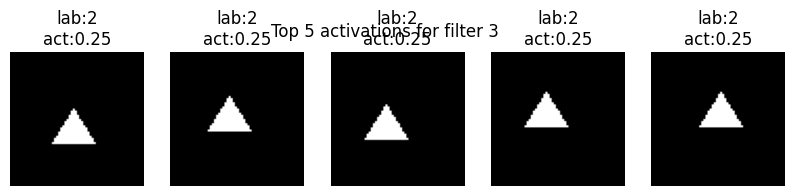

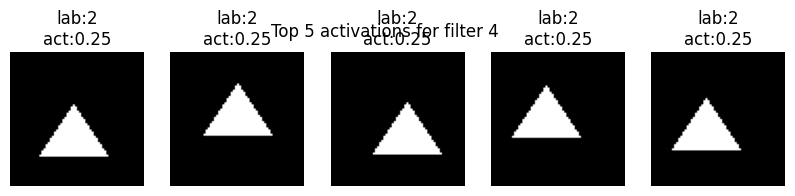

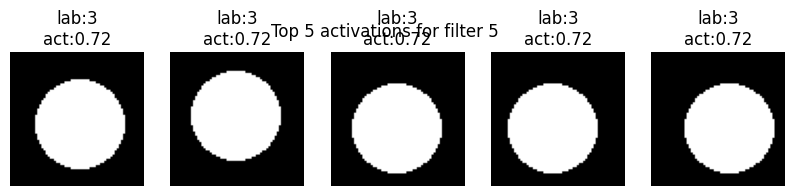

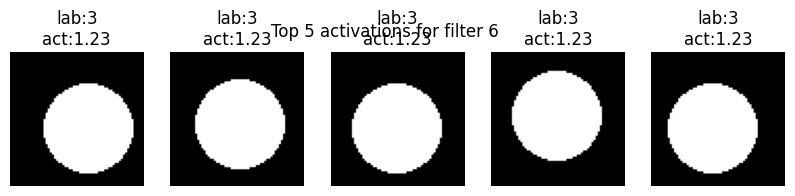

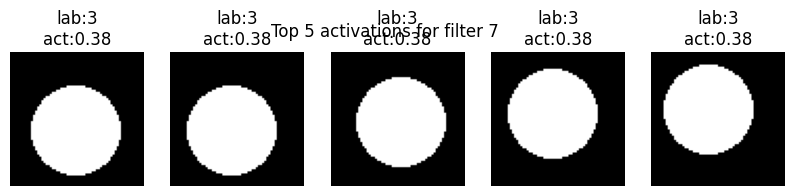

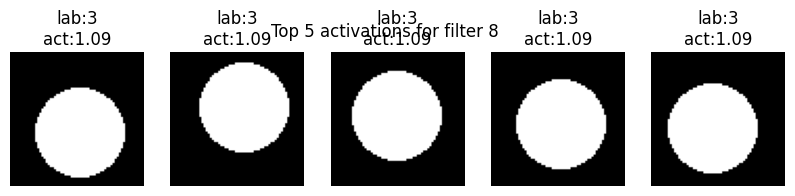

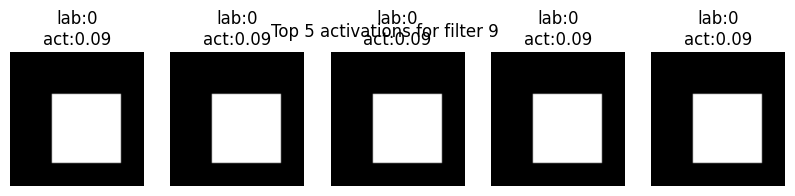

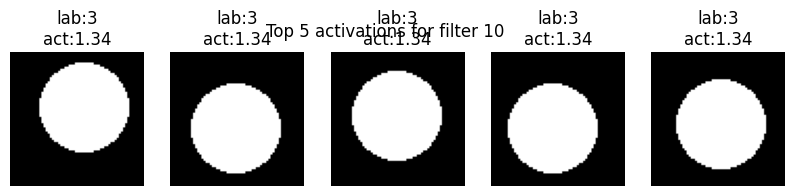

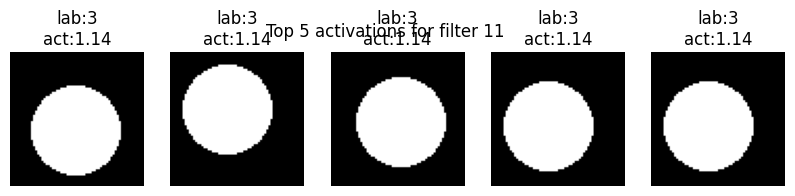

In [ ]:
# For each filter, compute mean activation over spatial dims and find top-k images
model.eval()
all_acts = []
all_imgs = []
all_labels = []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        logits, acts = model(xb, return_acts=True)
        # acts['conv2'] shape: B x 12 x H' x W'
        mean_act = acts['conv2'].mean(dim=[2,3]).cpu().numpy()  # B x 12
        all_acts.append(mean_act)
        all_imgs.append(xb.cpu())
        all_labels.extend(yb.numpy().tolist())

all_acts = np.vstack(all_acts)  # N x 12
all_imgs = torch.cat(all_imgs, dim=0)
labels_arr = np.array(all_labels)

top_k = 5
for f in range(all_acts.shape[1]):
    idxs = np.argsort(-all_acts[:,f])[:top_k]
    plt.figure(figsize=(10,2))
    for i,ind in enumerate(idxs):
        plt.subplot(1,top_k,i+1)
        plt.imshow(all_imgs[ind].squeeze().numpy(), cmap='gray')
        plt.title(f"lab:{labels_arr[ind]}\nact:{all_acts[ind,f]:.2f}")
        plt.axis('off')
    plt.suptitle(f"Top {top_k} activations for filter {f}")
    plt.show()


Interprtation:

Filters 0 and 2 activate strongly for class 3 (circle), indicating they detect curved edges or round boundaries. Meanwhile, filters 1, 3, and 4 respond mainly to class 2 (triangle) images, suggesting they specialize in recognizing sharp corners and angular shapes.

Filters 7, 8, 10, and 11 all activate strongly for class 3 (circle) images, suggesting they detect curved or round patterns characteristic of circles. In contrast, filter 9 responds to class 0 (square) images, indicating it captures straight edges or angular boundaries.


Ablation (turn filters off)

For one chosen image, it turns off one filter at a time in the second conv layer, then measures how much the model’s confidence drops for the correct class.

Input:One test image (and its true label).

Output:A bar chart showing how much each filter affects the prediction.

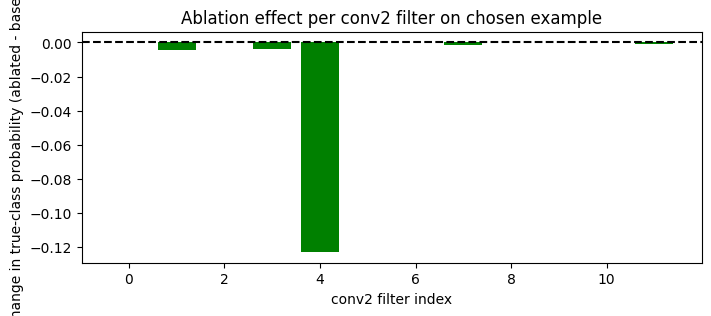

Filter 1 changed prob by -0.004
Filter 3 changed prob by -0.004
Filter 4 changed prob by -0.123
Filter 7 changed prob by -0.002
Filter 11 changed prob by -0.001


In [ ]:
# Ablation sweep of conv2 filters (Fix A: only get logits)
model.eval()
ex_img = ex_img.to(device)   # make sure example is on correct device
with torch.no_grad():
    baseline_logits = model(ex_img)            # returns only logits by default
    baseline_prob = F.softmax(baseline_logits, dim=1)[0, ex_label].item()

changes = []
with torch.no_grad():
    a1 = F.relu(model.conv1(ex_img))
    p1 = model.pool(a1)
    a2 = F.relu(model.conv2(p1))  # 1 x 12 x H' x W'
    for f in range(a2.shape[1]):
        mod = a2.clone()
        mod[:, f, :, :] = 0.0
        flat = mod.flatten(start_dim=1)
        h = F.relu(model.fc1(flat))
        out = model.fc2(h)
        prob = F.softmax(out, dim=1)[0, ex_label].item()
        changes.append(prob - baseline_prob)

# plot
plt.figure(figsize=(8,3))
colors = ['green' if c<0 else 'red' if c>0 else 'gray' for c in changes]
plt.bar(range(len(changes)), changes, color=colors)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("conv2 filter index")
plt.ylabel("Change in true-class probability (ablated - baseline)")
plt.title("Ablation effect per conv2 filter on chosen example")
plt.show()

for i,c in enumerate(changes):
    if abs(c) > 1e-3:
        print(f"Filter {i} changed prob by {c:+.3f}")


Interpretation:

This tells us which filters are most important. The ablation test for this single example shows that removing filter 4 causes the largest drop in prediction confidence, meaning this filter is crucial for identifying that shape. Other filters have minimal effect, suggesting they play a smaller or redundant role in the decision.

Average ablation across many images

Perform ablation across many validation images.
Then average the effect for each filter.

Input: All validation images.

Output: A bar chart showing average importance of each filter.

Why: Instead of just one image, this gives a general picture of which filters matter most overall for the model’s understanding.

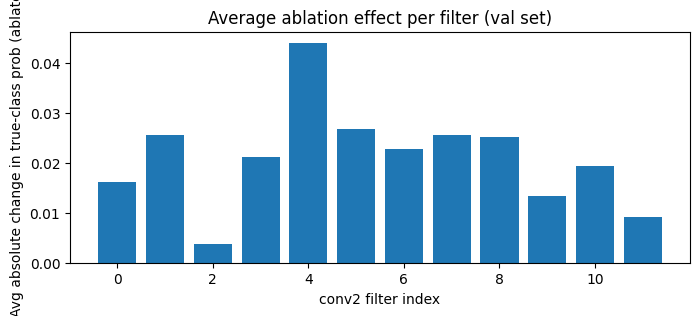

Filter 0 -> avg abs change 0.016
Filter 1 -> avg abs change 0.026
Filter 3 -> avg abs change 0.021
Filter 4 -> avg abs change 0.044
Filter 5 -> avg abs change 0.027
Filter 6 -> avg abs change 0.023
Filter 7 -> avg abs change 0.026
Filter 8 -> avg abs change 0.025
Filter 9 -> avg abs change 0.013
Filter 10 -> avg abs change 0.019


In [ ]:
# For each filter, zero it across many validation images and compute the average absolute change in predicted probability for the true class.
model.eval()
filter_count = model.conv2.out_channels
acc_changes = np.zeros(filter_count)
n_total = 0
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device); yb = yb.to(device)
        # baseline probs
        logits, acts = model(xb, return_acts=True)
        probs = F.softmax(logits, dim=1)
        baseline_true = probs[range(len(yb)), yb].cpu().numpy()  # B
        a1 = F.relu(model.conv1(xb))
        p1 = model.pool(a1)
        a2 = F.relu(model.conv2(p1))  # B x F x H' x W'

        for f in range(filter_count):
            mod = a2.clone()
            mod[:, f, :, :] = 0.0
            flat = mod.flatten(start_dim=1)
            h = F.relu(model.fc1(flat))
            out = model.fc2(h)
            probs_mod = F.softmax(out, dim=1)
            true_mod = probs_mod[range(len(yb)), yb].cpu().numpy()
            acc_changes[f] += np.abs(true_mod - baseline_true).sum()
        n_total += xb.size(0)

acc_changes /= n_total

plt.figure(figsize=(8,3))
plt.bar(range(filter_count), acc_changes)
plt.xlabel("conv2 filter index")
plt.ylabel("Avg absolute change in true-class prob (ablated)")
plt.title("Average ablation effect per filter (val set)")
plt.show()

for i,c in enumerate(acc_changes):
    if c > 0.01:
        print(f"Filter {i} -> avg abs change {c:.3f}")


Interpretation:

The ablation results show that filter 4 has the highest impact on the model’s predictions, indicating it captures the most important visual feature for shape recognition. Filters with smaller changes contribute less, suggesting they encode less critical or redundant features.

Occlusion test

Block small parts (patches) of an image and sees how the model’s confidence changes.
If blocking the middle of a circle makes the model less sure, then the middle is important.

Input: One image, patch size, and stride (how far we move the patch each time).
Output:
A heatmap showing which parts of the image matter most (bright areas = more important).


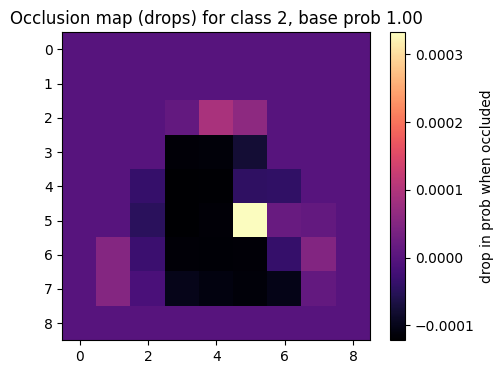

In [ ]:
# Colab Cell 12: Simple occlusion map for a chosen example (sliding patch)
# Slide a small black patch across the input and see how predicted probability for true class changes.
def occlusion_map(img_tensor, model, patch_size=10, stride=6):
    # img_tensor: 1 x 1 x H x W, values 0..1
    H = img_tensor.shape[2]; W = img_tensor.shape[3]
    base_logits = model(img_tensor)
    base_prob = F.softmax(base_logits, dim=1)[0, ex_label].item()
    heat = np.zeros(((H - patch_size)//stride + 1, (W - patch_size)//stride + 1))
    ys = range(0, H-patch_size+1, stride)
    xs = range(0, W-patch_size+1, stride)
    with torch.no_grad():
        for i,y in enumerate(ys):
            for j,x in enumerate(xs):
                mod = img_tensor.clone()
                mod[:,:, y:y+patch_size, x:x+patch_size] = 0.0
                logits = model(mod)
                prob = F.softmax(logits, dim=1)[0, ex_label].item()
                heat[i,j] = base_prob - prob  # how much removing this patch reduces prob
    return heat, ys, xs, base_prob

heat, ys, xs, base_prob = occlusion_map(ex_img.to(device), model, patch_size=12, stride=6)
plt.figure(figsize=(5,4))
plt.imshow(heat, cmap='magma', interpolation='nearest')
plt.colorbar(label='drop in prob when occluded')
plt.title(f"Occlusion map (drops) for class {ex_label}, base prob {base_prob:.2f}")
plt.show()


Interpretation:

For triangle (class 2), base prob 1.00 means the model was 100% sure before any occlusion.
The occlusion map shows that the model’s prediction confidence drops mainly when the central region of the image is hidden, indicating that it focuses on the core area of the shape for classification. Darker regions have little effect, meaning the background contributes minimally to the decision.

Summary:

We see here that, one of the most influential components in this model is filter 4 in the second convolution layer. Ablation results showed that removing this filter caused the largest drop in prediction confidence, revealing its key role in identifying angular boundaries of shapes.
Visualizations confirmed that this filter activates strongly on triangle edges and corners, suggesting it functions as a triangle-edge detector. The activation maps, top-activating images, and kernel patterns together show that the model builds up shape understanding by combining simple edge detectors (like filter 4) into higher-level geometric recognition.

We see how the different filters in a CNN behave like specialized “mini-experts,” each focusing on specific visual cues such as curves or corners. It was surprising to see how clearly some filters corresponded to real geometric features. The hardest part was interpreting overlapping activations as some filters seemed to respond to multiple shapes.

To explore deeper, we should look at interpretability methods, like feature inversion or activation maximization, to better visualize exactly what each neuron sees.

Citation: I did use Chat GPT to help with the code and to understand the concepts, process and interpretability of how neural networks classify images. 11/7/202702:13PM